In [1]:
# general tools
import sys
import time
from glob import glob

# data tools
import zarr
import h5py
import random
from datetime import datetime, timedelta
import numpy as np
from random import shuffle
from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras

from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
from keras_unet_collection import layer_utils as k_layers
from keras_unet_collection.activations import GELU

2022-08-27 22:31:20.601855: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [4]:
lead = 21

In [5]:
means = [
    -6.335041783675384,
    101598.30648208999,
    2.4340308170812857,
    0.0238316214287872,
    0.0115228964831135,
    0.015723252607236175,
    0.00010298927478466365,
    0.00013315081911787703,
    0.02022990418418194,
    285.1588453352469,
    280.69456763975046,
    0.18025322895802864,
    -0.35625256772098957,
    4.466962100212334,
    0.10710428466431396,
    311.51020050786116,
    -22.95554152474839,
    95.80303950026172,
    41.22773039479408,
    2.696538199313979,
    0.257023643073863,
    11.80181492281666,
    0.15778718430103703,
];

stds = [
    8.872575669978966,
    672.3339463894478,
    7.555104640235371,
    0.5696550725786566,
    0.2283199203388272,
    0.37333362094670486,
    0.00022281640603195643,
    0.0002413561909874066,
    0.3589573748563584,
    11.553795616392204,
    12.101590155483459,
    3.1758721705443826,
    3.6588052023281175,
    2.6995797278745948,
    0.9896017905552607,
    748.8376068157106,
    78.895180023938,
    104.17948262883918*2,
    77.25788246299936*2,
    5.35086729614372,
    5.438075471238217,
    11.440203318938076,
    11.327741531273508
];


In [6]:
ind_pick = [0, 1, 3, 4, 5, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

log_norm = [True, False, True, True, True, True, True, True, True, False, False, 
            False, False, True, True, True, True, False, False, False, False, False, False]

sparse = [True, False, True, True, True, True, True, True, True, False, False, 
          False, False, False, True, True, True, False, False, False, False, False, False]



In [7]:
#HRRRv3_lead = zarr.load(save_dir_scratch+'HRRR_{:02}_v3.zarr'.format(lead))

HRRRv3_lead = np.zeros((872, 1059, 1799, 23))

In [8]:
def neighbour_leads(lead):
    out = [lead-2, lead-1, lead, lead+1, lead+2]
    flag_shift = [0, 0, 0, 0, 0]
    
    for i in range(5):
        if out[i] < 0:
            out[i] = 24+out[i]
            flag_shift[i] = -1
        if out[i] > 23:
            out[i] = out[i]-24
            flag_shift[i] = +1
            
    return out, flag_shift

In [9]:
lead_window, flag_shift = neighbour_leads(lead)

In [10]:
record_all = ()

for i, lead_temp in enumerate(lead_window):
    
    flag_ = flag_shift[i]
    if lead_temp > 0:
        with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_all.hdf'.format(lead_temp), 'r') as h5io:
            record_temp = h5io['record_v3'][...]

        if flag_shift[i] == 0:
            record_all = record_all + (record_temp,)

        if flag_shift[i] == -1:
            record_temp[1:, ...] = record_temp[:-1, ...]
            record_temp[0, ...] = np.nan
            record_all = record_all + (record_temp,)

        if flag_shift[i] == +1:
            record_temp[:-1, ...] = record_temp[1:, ...]
            record_temp[-1, ...] = np.nan
            record_all = record_all + (record_temp,)


shape_record = record_temp.shape      
record_v3 = np.empty(shape_record)
record_v3[...] = np.nan

for i in range(len(record_all)):
    record_temp = record_all[i]
    for day in range(shape_record[0]):
        for ix in range(shape_record[1]):
            for iy in range(shape_record[2]):
                if np.logical_not(np.isnan(record_temp[day, ix, iy])):
                    record_v3[day, ix, iy] = record_temp[day, ix, iy]
    

In [11]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_72km = h5io['lon_72km'][...]
    lat_72km = h5io['lat_72km'][...]
    
shape_72km = lon_72km.shape
shape_3km = lon_3km.shape
grid_shape = (872, 1059, 1799, 23)

In [12]:
indx_array = np.empty(shape_72km)
indy_array = np.empty(shape_72km)

gridTree = cKDTree(list(zip(lon_3km.ravel(), lat_3km.ravel()))) #KDTree_wraper(xgrid, ygrid)

for xi in range(shape_72km[0]):
    for yi in range(shape_72km[1]):
        
        temp_lon = lon_72km[xi, yi]
        temp_lat = lat_72km[xi, yi]
        
        dist, indexes = gridTree.query(list(zip(np.array(temp_lon)[None], np.array(temp_lat)[None])))
        indx_3km, indy_3km = np.unravel_index(indexes, shape_3km)
        
        indx_array[xi, yi] = indx_3km[0]
        indy_array[xi, yi] = indy_3km[0]

In [13]:
input_size = 128
half_margin = 64

day_start = 595+41
day_end = day_start+12
N_valid = day_end - day_start

# 15 days max

In [14]:
N_vars = len(ind_pick)

single_day = np.empty((1,)+grid_shape[1:3]+(N_vars,))
single_day[...] = np.nan

N_per_day = 2691

TEST_input = np.empty((N_valid*N_per_day, input_size, input_size, N_vars))
TEST_target = np.empty((N_valid*N_per_day))

In [ ]:

count = 0
for iday, day in enumerate(range(day_start, day_end, 1)):
    #print('Process day: {}'.format(day))
    #start_time = time.time()
    for c, v in enumerate(ind_pick):
        temp = HRRRv3_lead[day, ..., v]
        if v == 0:
            temp[temp<0] = 0
        if log_norm[v]:
            temp = np.log(np.abs(temp)+1)
        else:
            temp = (temp - means[v])/stds[v]

        single_day[..., c] = temp

    for xi in range(shape_72km[0]):
        for yi in range(shape_72km[1]):
            
            indx_3km = int(indx_array[xi, yi])
            indy_3km = int(indy_array[xi, yi])

            x_edge_left = indx_3km - half_margin
            x_edge_right = indx_3km + half_margin

            y_edge_bottom = indy_3km - half_margin
            y_edge_top = indy_3km + half_margin

            if x_edge_left >= 0 and y_edge_bottom >= 0 and x_edge_right <= shape_3km[0] and y_edge_top <= shape_3km[1]:

                TEST_input[count, ...] = single_day[0, x_edge_left:x_edge_right, y_edge_bottom:y_edge_top, :]
                TEST_target[count] = record_v3[day, xi, yi]
                count += 1
                
    #print("--- %s seconds ---" % (time.time() - start_time))

In [17]:
np.sum(np.logical_not(np.isnan(TEST_target)))

169

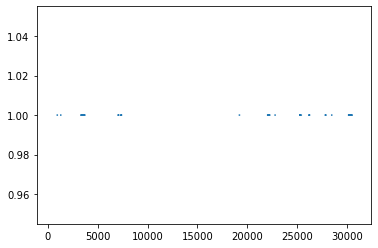

In [16]:
plt.plot(TEST_target)

In [32]:
2691*15

40365

In [51]:
110500/2691

41.06280193236715

In [52]:
145000/2691

53.88331475287997

In [9]:
IN = tf.keras.Input((128, 128, 19))

X = IN

X = k_layers.CONV_stack(X, 32, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack1')
X = tf.keras.layers.Conv2D(32, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv1')(X)

X = k_layers.CONV_stack(X, 64, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack2')
X = tf.keras.layers.Conv2D(64, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv2')(X)

X = k_layers.CONV_stack(X, 128, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack3')
X = tf.keras.layers.Conv2D(128, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv3')(X)

X = k_layers.CONV_stack(X, 256, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack4')
X = tf.keras.layers.Conv2D(256, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv4')(X)

X = k_layers.CONV_stack(X, 512, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack5')
X = tf.keras.layers.Conv2D(512, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv5')(X)

D = tf.keras.layers.Flatten()(X)

D = tf.keras.layers.Dense(512, use_bias=False, name='dense1')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn1')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(128, use_bias=False, name='dense2')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn2')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(1, activation='sigmoid', name='head')(D)
#D = tf.keras.layers.Softmax()(D)

OUT = D

2022-08-25 17:12:49.293248: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-25 17:12:49.294624: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-25 17:12:49.346237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-25 17:12:49.346283: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-25 17:12:49.348797: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-25 17:12:49.348864: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [10]:
model = keras.models.Model(inputs=[IN,], outputs=[OUT,])
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=0))

In [11]:
# temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

# key = 'BIG10'

# model_name = '{}_tornado'.format(key)
# model_path = temp_dir+model_name

# W_new = k_utils.dummy_loader(model_path)

# model.set_weights(W_new)

In [21]:
start_time = time.time()

pred = model.predict([TEST_input[:40000, ...],])

print("--- %s seconds ---" % (time.time() - start_time))

--- 338.5734794139862 seconds ---


In [20]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
40000/2691

14.864362690449648